In [1]:
import numpy as np
from numpy.linalg import norm

import random
import math
from math import isinf

from scipy.special import rel_entr

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=12) 

In [2]:
################## DATA FRAME ##################
datafile = 'Data/Fitbit_Kaggle/dailyActivity_merged.csv'
fields = ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 
          'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 
          'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

#pd.set_option('display.max_rows', 100)
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
selected_data = df[['Id','FairlyActiveMinutes', 'TotalSteps']]
n_rows, n_cols = df.shape
len(df['Id'].unique())

33

In [3]:
def reportNoisyMax(values, epsilon):
    '''
    Report differentially private noisy max - > from Section3: https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf
    '''
    rVals = list()
    for val in values:
        rval = val + np.random.laplace(0,2.0/epsilon)
        rVals.append(rval)
    
    #print(rVals)
    max_value = max(rVals)
    max_index = rVals.index(max_value)
    noisy_max = values[max_index] + np.random.laplace(0,2.0/epsilon)
    return noisy_max
        

In [4]:
values = list(selected_data['FairlyActiveMinutes'].unique())
print(values)
max(values)

[13, 19, 11, 34, 10, 20, 16, 31, 12, 8, 27, 21, 5, 14, 23, 28, 35, 15, 24, 22, 6, 46, 0, 7, 18, 36, 63, 51, 58, 4, 42, 33, 1, 41, 53, 71, 94, 17, 9, 3, 29, 26, 40, 2, 47, 25, 32, 48, 72, 43, 83, 95, 67, 98, 92, 52, 143, 96, 88, 55, 86, 116, 122, 115, 38, 39, 45, 56, 30, 66, 125, 37, 54, 74, 65, 113, 50, 69, 59, 44, 91]


143

In [5]:
privmax = reportNoisyMax(values, 1.0)
print(int(privmax))

140


In [6]:
def blockRR(value, blocks, pB):
    '''
    Perform block/interval randomized response
    with prob pB the original block is kept, (1-pB) we choose a random block
    '''
    
    valB = None
    for i in range(0, len(blocks)):
        if value in blocks[i]:
            valB = i
            break
            
    if valB is None:
        valB = len(blocks)-1
    
    #print(str(value)+" "+str(valB))
    p = random.random()
    
    if p<=pB:
        privVal = random.choice(blocks[valB])
    else:
        otherVal = list()
        for j in range(0, len(blocks)):
            if j!=valB:
                otherVal.extend(blocks[j])
                
        privVal = random.choice(otherVal)
        
    return privVal

In [7]:
#Divide the rande [0,150] into buckets of 10
blocks = list()
block = list()
for i in range(0, 151):
    block.append(i)
    if len(block)>=10:
        blocks.append(block)
        block = list()
        
print(blocks)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [110, 111, 112, 113, 114, 115, 116, 117, 118, 119], [120, 121, 122, 123, 124, 125, 126, 127, 128, 129], [130, 131, 132, 133, 134, 135, 136, 137, 138, 139], [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]


In [8]:
def sanitizeActProfile(IDs, individualAct, pB, memo=False):
    
    allPrivAct = dict()
    for Id in IDs:
        privAct = list()
        privmap = dict()
        
        if memo:
            for val in set(individualAct[Id]):
                pval = blockRR(val, blocks, pB)
                privmap[val] = pval

            for val in individualAct[Id]:
                privAct.append(privmap[val])
        else:
            for val in individualAct[Id]:
                pval = blockRR(val, blocks, pB)
                privAct.append(pval)
                
        allPrivAct[Id]=privAct
    return allPrivAct

In [9]:
IDs = selected_data['Id'].unique()
individualAct = dict()
selectedIDs = IDs
for Id in selectedIDs:
    act = selected_data[selected_data['Id']==Id]
    individualAct[Id] = act['FairlyActiveMinutes'].tolist()

In [10]:
#Sanitize without memoization
pB=0.85
sanProfiles = sanitizeActProfile(IDs,individualAct,pB)

In [11]:
#Sanitize with memoization
pB=0.85
sanProfilesM = sanitizeActProfile(IDs,individualAct,pB,True)

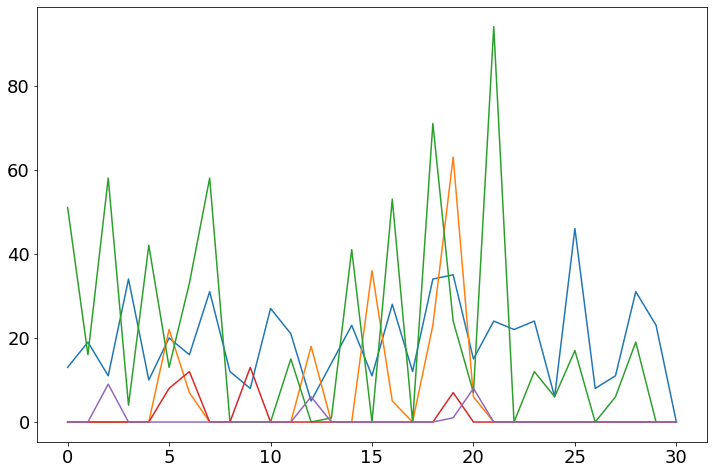

In [12]:
plotIDs = IDs[:5]
for Id in plotIDs:
    plt.plot(individualAct[Id])

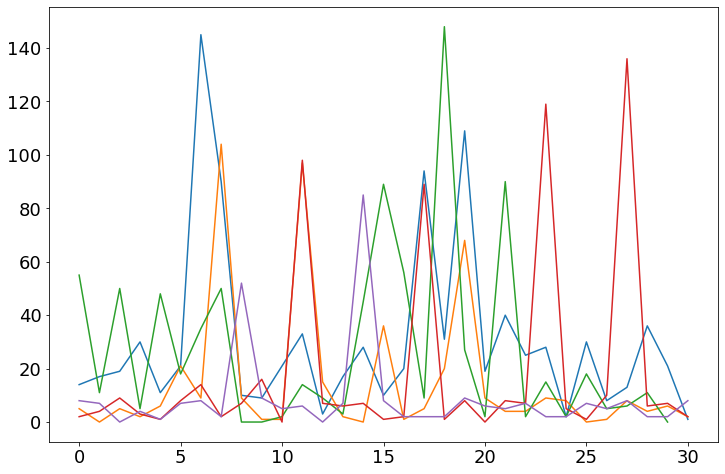

In [13]:
for Id in plotIDs:
    plt.plot(sanProfiles[Id])

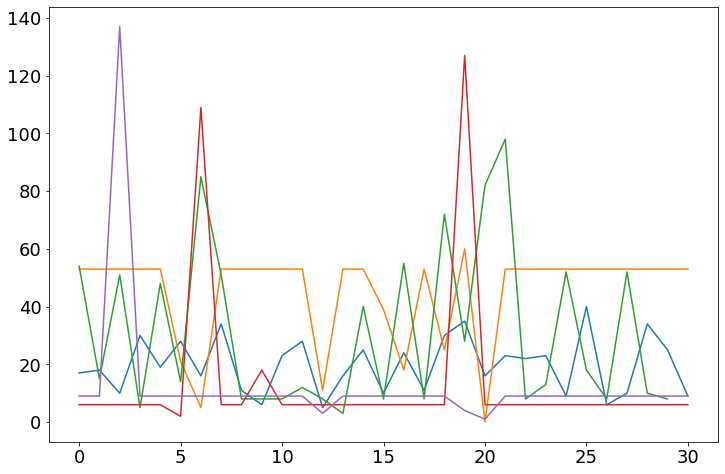

In [14]:
for Id in plotIDs:
    plt.plot(sanProfilesM[Id])

In [15]:
def getFreqRep(maxVal, values):
    freqVec = [0.0]*(maxVal+1)
    tot_val = 0.0
    for val in values:
        freqVec[val] = freqVec[val] + 1.0
        tot_val = tot_val + 1
        
    for i in range(0,len(freqVec)):
        freqVec[i] = (1.0*freqVec[i])/tot_val + 10**-6
        
    print(tot_val)
    return freqVec


def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [16]:
ep_list = [0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
smol = 0.00001
LEP = len(ep_list)
euc_dist, euc_dist_M = [0]*LEP, [0]*LEP
#orgP_bins, sanP_bins, sanPM_bins = [0]*LEP, [0]*LEP, [0]*LEP
sanP_diff, sanPM_diff = [0]*LEP, [0]*LEP
sanP_diff_KL, sanP_diff_l1, sanP_diff_maxEr = [0]*LEP, [0]*LEP, [0]*LEP

for i, epsilon in enumerate(ep_list):
    B = len(blocks)
    pB = math.exp(epsilon)/(B-1+math.exp(epsilon))
    sanProfiles = sanitizeActProfile(IDs,individualAct,pB)
    sanProfilesM = sanitizeActProfile(IDs,individualAct,pB,True)

    running_sum, running_euc = 0, 0
    running_sum_M, running_euc_M = 0, 0
    orgP, sanP, sanPM = list(), list(), list()
    for Id in plotIDs:
        sp_ID = np.array(sanProfiles[Id])
        spM_ID = np.array(sanProfilesM[Id])
        in_ID = np.array(individualAct[Id])
        
        orgP.extend(individualAct[Id])
        sanP.extend(sanProfiles[Id])
        sanPM.extend(sanProfilesM[Id])

        #running_sum = running_sum + abs(norm(sp_ID-in_ID))
        running_euc = running_euc + (norm(sp_ID-in_ID))**2

        #running_sum_M = running_sum_M + abs(norm(spM_ID-in_ID))
        running_euc_M = running_euc_M + (norm(spM_ID-in_ID))**2
        
    print('FOR THE HISTOGRAMS')
    #sanP_diff[i] = sum(rel_entr(np.array(orgP)+smol,np.array(sanP)+smol))
    #sanPM_diff[i] = sum(rel_entr(np.array(orgP)+smol,np.array(sanPM)+smol))
    
    maxValO = max(orgP)
    print(maxValO)
    maxValS = max(sanP)
    print(maxValS)
    maxVal = max(maxValO,maxValS)
    print(maxVal)

    orgFreqVec = getFreqRep(maxVal, orgP)
    sanFreqVec = getFreqRep(maxVal, sanP)
    
    sanP_diff_KL[i] = KL(orgFreqVec,sanFreqVec)
    sanP_diff_l1[i] = np.linalg.norm(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float),ord=1)
    sanP_diff_maxEr[i] = max(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float))

    euc_dist[i] = np.sqrt(running_euc) / len(plotIDs)
    #avg_dist = running_sum / len(plotIDs)
    euc_dist_M[i] = np.sqrt(running_euc_M) / len(plotIDs)
    #avg_dist_M = running_sum_M / len(plotIDs)

FOR THE HISTOGRAMS
94
144
144
154.0
154.0
FOR THE HISTOGRAMS
94
147
147
154.0
154.0
FOR THE HISTOGRAMS
94
149
149
154.0
154.0
FOR THE HISTOGRAMS
94
147
147
154.0
154.0
FOR THE HISTOGRAMS
94
146
146
154.0
154.0
FOR THE HISTOGRAMS
94
96
96
154.0
154.0


C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\i

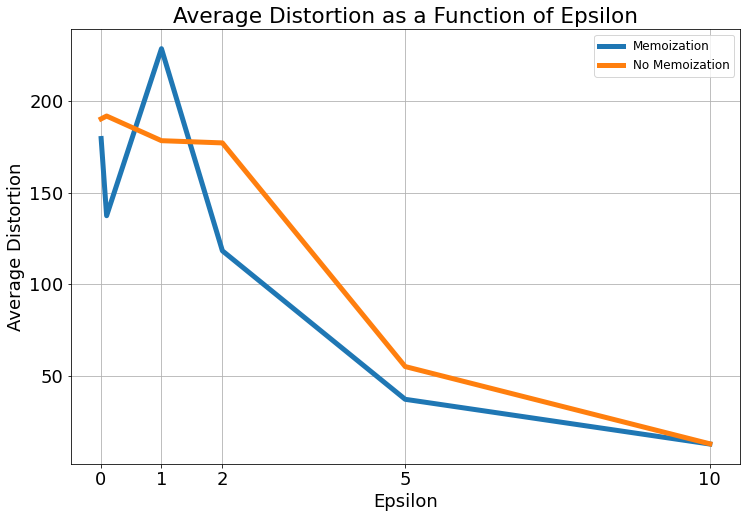

In [17]:
plt.plot(ep_list, euc_dist_M, label='Memoization', linewidth=5)
plt.plot(ep_list, euc_dist,  label='No Memoization', linewidth=5)
plt.title('Average Distortion as a Function of Epsilon')
plt.ylabel('Average Distortion')
plt.xlabel('Epsilon')
plt.legend()
plt.xticks([0, 1.0, 2.0, 5.0, 10.0])
plt.grid()
plt.show()

## Histogram Comparison

In [18]:
orgP = list()
sanP = list()
sanPM = list()
for Id in IDs:
    orgP.extend(individualAct[Id])
    sanP.extend(sanProfiles[Id])
    sanPM.extend(sanProfilesM[Id])
    
orgP = np.array(orgP)+smol
sanP = np.array(sanP)+smol
sanPM = np.array(sanPM)+smol

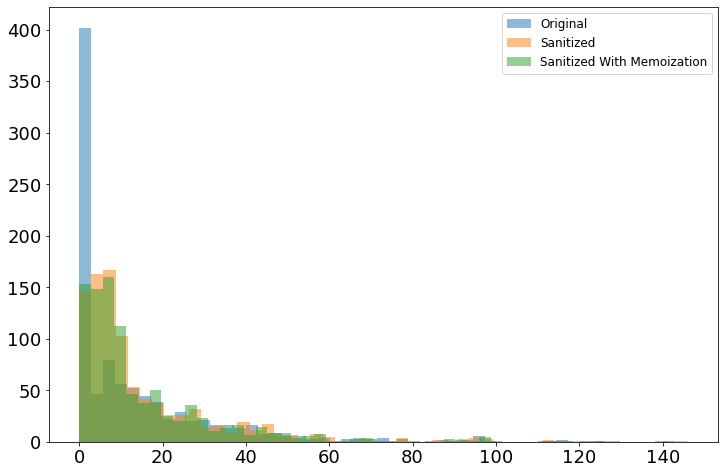

In [19]:

plt.hist(orgP, 50, alpha=0.5, label='Original')
plt.hist(sanP, 50, alpha=0.5, label='Sanitized')
plt.hist(sanPM, 50, alpha=0.5, label='Sanitized With Memoization')
plt.legend(loc='upper right')
plt.show()

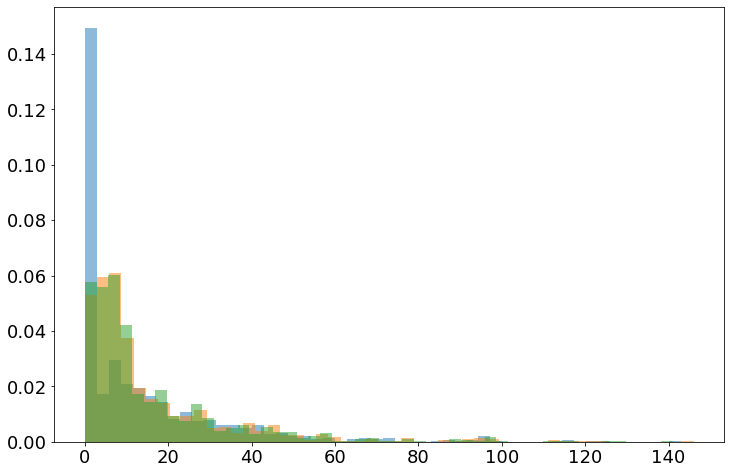

In [20]:
k=(3,3,3,3)
#x, bins, p=plt.hist(k, density=True)  # used to be normed=True in older versions

xO, binsO, pO = plt.hist(orgP, 50, density=True, alpha=0.5, label='Original')
xP, binsP, pP = plt.hist(sanP, 50, density=True, alpha=0.5, label='Sanitized')
xPM, binsPM, pPM = plt.hist(sanPM, 50, density=True, alpha=0.5, label='Sanitized With Memoization')

xO = np.array(xO)+smol
xP = np.array(xP)+smol
xPM = np.array(xPM)+smol

In [21]:
sanP_diff_maxEr

[0.564935064935065,
 0.5584415584415585,
 0.551948051948052,
 0.538961038961039,
 0.5,
 0.525974025974026]

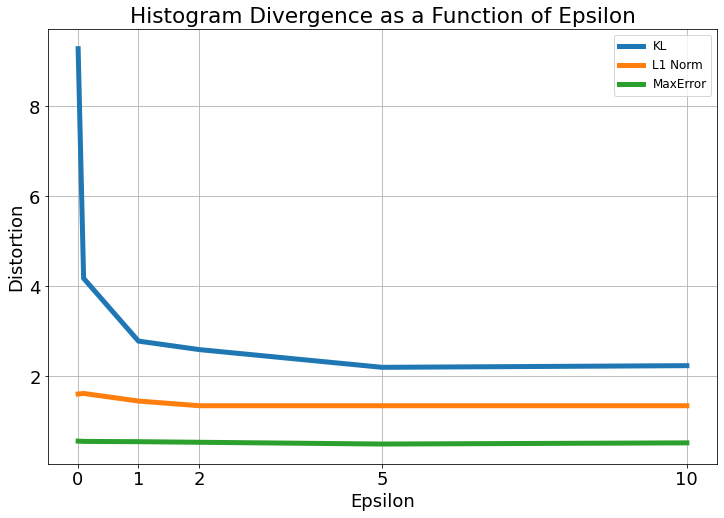

In [23]:
plt.plot(ep_list, sanP_diff_KL, label='KL', linewidth=5)
plt.plot(ep_list, sanP_diff_l1,  label='L1 Norm', linewidth=5)
plt.plot(ep_list, sanP_diff_maxEr,  label='MaxError', linewidth=5)
plt.title('Histogram Divergence as a Function of Epsilon')
plt.ylabel('Distortion')
plt.xlabel('Epsilon')
plt.legend()
plt.xticks([0, 1.0, 2.0, 5.0, 10.0])
plt.grid()
plt.show()

In [23]:
for i, epsilon in enumerate(ep_list):       
    sanP_diff[i] = sum(rel_entr(np.array(xO),np.array(xP)))
    sanPM_diff[i] = sum(rel_entr(np.array(xO),np.array(xPM)))

In [24]:
sanP_diff

[0.0885601659376549,
 0.0885601659376549,
 0.0885601659376549,
 0.0885601659376549,
 0.0885601659376549,
 0.0885601659376549]

In [25]:
sanPM_diff

[0.12379918338636448,
 0.12379918338636448,
 0.12379918338636448,
 0.12379918338636448,
 0.12379918338636448,
 0.12379918338636448]

## Choosing Epsilon for indistinguishability at block level

How we choose pB for a single release?

$\frac{Pr[M(b_1)=b']}{Pr[M(b_2)=b']} = \frac{p_B}{((1-p_B)/|B|-1)} <= e^\epsilon$
<br>
<br>
$p_B <= \frac{e^\epsilon}{(|B|-1+e^\epsilon)}$

where |B| = number of intervals/blocks, and \epsilon privacy parameter

In [32]:
epsilon = 5.0
B = len(blocks)
pB = math.exp(epsilon)/(B-1+math.exp(epsilon))
print(pB)

0.9138000881372063


## Choosing Epsilon for indistinguishability at value level

$\frac{Pr[M(v_1)=v']}{Pr[M(v_2)=v']} = \frac{(\frac{p_B}{m})}{((1-p_B)(\frac{1}{(n-m)})} <= e^\epsilon$
<br>
<br>
$p_B <= \frac{e^\epsilon}{(e^\epsilon+\frac{n}{m}+1)}$

where n = domain, m=size of the interval

In [33]:
epsilon = 5.0
n=max(selected_data['FairlyActiveMinutes'])
m=max(len(x) for x in blocks)
pB = math.exp(epsilon)/(math.exp(epsilon)+n/m-1)
print(pB)

0.9177556107752266


# Some Ideas
## Group indistiguishability:
Provide indistinguishability across group of individuals. For example, we can create 3 groups (non-active, medium active, very active) of users based on their activites. Then, we can modify our randomized response methods to provide indistinguishability within each group. This is a relaxed version of the privacy model, but it should improve usability.

Tasks:
1. use data drive approaches to create groups of individuals
2. measure the uniqueness in each group